The central idea of this tutorial is to explore LSTM based models. We will explore how the size of the model effects the sequence generated. We will see both character based and word based models.

## Word Based LSTM model


In [2]:
import numpy
import re
import pandas as pd
import numpy as np
import keras
import string
import nltk

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

string.punctuation = string.punctuation + '“' + '”' +'-' + '’' + '‘' + '—'
string.punctuation = string.punctuation.replace('.', '')

We do basic pre processing which includes lowering etc. after looking at the dataset.<br>
I use different text processing codes for each class. Examine all of them to know this process better.

In [4]:
# Loads the data and preprocesses data and stores corpus in raw_text
raw_text = open('../../Data/corpus.txt', encoding = 'utf8').read()

file_nl_removed = ""
for line in raw_text:
  line_nl_removed = line.replace("\n", " ")           #removes newlines
  file_nl_removed += line_nl_removed

file_p = "".join([char for char in file_nl_removed if char not in string.punctuation])   #removes all special characters
sents = nltk.sent_tokenize(file_p)
print("The number of sentences is", len(sents)) #prints the number of sentences

string.punctuation = string.punctuation + '.'
file_q = "".join([char for char in file_p if char not in string.punctuation])   #removes even periods.
words = nltk.word_tokenize(file_q)
print("The number of tokens is", len(words)) #prints the number of tokens

average_tokens = round(len(words)/len(sents))
print("The average number of tokens per sentence is", average_tokens) #prints the average number of tokens per sentence

unique_tokens = set(words)
print("The number of unique tokens are", len(unique_tokens)) #prints the number of unique tokens

preprocessed_text = file_p.lower()       #converts corpus into lowercase

The number of sentences is 981
The number of tokens is 26381
The average number of tokens per sentence is 27
The number of unique tokens are 3037


In [5]:
# Hyperparameters of the model
vocab_size = 2750  #chosen based on statistics of the model
oov_tok = '<OOV>'
embedding_dim = 100
padding_type='post'
trunc_type='post'

In [6]:
# tokenizes sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts([preprocessed_text])
word_index = tokenizer.word_index

In [7]:
seq_length = 50;
tokens = tokenizer.texts_to_sequences([preprocessed_text])[0]

In [8]:
dataX = []
dataY = []

for i in range(0, len(tokens) - seq_length-1 , 1):
  seq_in = tokens[i:i + seq_length]
  seq_out = tokens[i + seq_length]

  if seq_out==1: #Skip samples where target word is OOV
    continue
    
  dataX.append(seq_in)
  dataY.append(seq_out)
 
N = len(dataX)
print ("Total training data size is -", N)

Total training data size is - 26333


In [9]:
X = numpy.array(dataX)

# one hot encodes the output variable
y = numpy.array(dataY)
y = np_utils.to_categorical(dataY)

In [10]:
# with embedding
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=seq_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(vocab_size, activation='softmax')
])

# compiles model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           275000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 2750)              354750    
                                                                 
Total params: 714,230
Trainable params: 714,230
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Uses validation split of 0.2 while training
num_epochs = 5
history = model.fit(X, y, epochs=num_epochs, batch_size = 128, verbose=1, validation_split=0.2)

Epoch 1/5


2023-05-15 14:48:03.043948: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


165/165 [==============================] - 10s 56ms/step - loss: 6.4357 - accuracy: 0.0547 - val_loss: 6.2589 - val_accuracy: 0.0849
Epoch 2/5
165/165 [==============================] - 9s 52ms/step - loss: 5.9622 - accuracy: 0.0560 - val_loss: 6.1929 - val_accuracy: 0.0851
Epoch 3/5
165/165 [==============================] - 8s 50ms/step - loss: 5.8336 - accuracy: 0.0594 - val_loss: 6.1830 - val_accuracy: 0.0908
Epoch 4/5
165/165 [==============================] - 8s 51ms/step - loss: 5.7273 - accuracy: 0.0671 - val_loss: 6.1647 - val_accuracy: 0.0934
Epoch 5/5
165/165 [==============================] - 9s 52ms/step - loss: 5.6364 - accuracy: 0.0703 - val_loss: 6.1750 - val_accuracy: 0.0953


In [12]:
#Creates word to idx map using tokenizer.word_index
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [17]:
# Returns the next n words greedily
def next_tokens(input_str, n):
    print ("Seed -",  input_str, sep = '\n\n')
    final_string = ''
    for i in range(n):
        token = tokenizer.texts_to_sequences([input_str])
        prediction = model.predict(token, verbose=0)
        final_string = final_string + reverse_word_map[numpy.argmax(prediction[0])] + ' ' 
        input_str = input_str + ' ' + reverse_word_map[numpy.argmax(prediction[0])]
        input_str = ' '.join(input_str.split(' ')[1:])
    return final_string

In [19]:
# picks a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
input_str = ' '.join([reverse_word_map[value] for value in pattern])

output = next_tokens(input_str, 10)
print("\nGenerated string -\n\n", output)

Seed -

had made her so savage when they met in the kitchen when im a duchess she said to herself not in a very hopeful tone though i wont have any pepper in my kitchen at all soup does very well withoutmaybe its always pepper that makes people hottempered she went

Generated string -

 the little little little little little little little little little 


In [20]:
input_str = "The boy laughed at the fright he had caused. This time, the villagers left angrily. The third day, as the boy went up\
 the small hill, he suddenly saw a wolf attacking his sheep. He cried as hard as he could, “Wolf! Wolf! Wolf!”, but not \
 a single villager came to help him. The villagers thought that he was trying to fool them again and did not come to rescue \
 him or his sheep."

# Uses first 50 tokens from given input_str as input. Since the seq_length is 50, only 50 tokens are taken using the tokenizer.
output = next_tokens(input_str, 10)
print("\nGenerated string -\n\n", output)

Seed -

The boy laughed at the fright he had caused. This time, the villagers left angrily. The third day, as the boy went up the small hill, he suddenly saw a wolf attacking his sheep. He cried as hard as he could, “Wolf! Wolf! Wolf!”, but not  a single villager came to help him. The villagers thought that he was trying to fool them again and did not come to rescue  him or his sheep.

Generated string -

 and the little little little little little little little little 


## Character based LSTM Model 1

In [21]:
# Uses the preprocessed data and create raw_text
raw_text = preprocessed_text   #periods have not been removed for better results

# creates mapping of unique characters to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

# Prints the total characters and character vocab size
n_chars = len(raw_text)
n_vocab = len(chars)

print("The number of total characters are", n_chars)
print("\nThe character vocab size is", n_vocab)

The number of total characters are 135031

The character vocab size is 29


In [22]:
#Prepares dataset where the input is sequence of 100 characters and target is next character.
seq_length = 100

dataX = []
dataY = []

for i in range(0, n_chars - seq_length, 1):
  seq_in = raw_text[i:i + seq_length]
  seq_out = raw_text[i + seq_length]

  dataX.append([char_to_int[char] for char in seq_in])
  dataY.append(char_to_int[seq_out])

n_patterns = len(dataX)
print ("Total Patterns: ", n_patterns)

Total Patterns:  134931


In [23]:
# reshapes X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))

# one hot encodes the output variable
y = np_utils.to_categorical(dataY)

In [24]:
embedding_dim =100
max_length =100

In [26]:
model = Sequential()
model.add(Embedding(n_vocab, embedding_dim, input_length=max_length))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          2900      
                                                                 
 lstm_2 (LSTM)               (None, 256)               365568    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 29)                7453      
                                                                 
Total params: 375,921
Trainable params: 375,921
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X, y, epochs = 20, batch_size=128)

Epoch 1/20
1055/1055 [==============================] - 256s 242ms/step - loss: 2.0904
Epoch 2/20
1055/1055 [==============================] - 256s 243ms/step - loss: 1.6336
Epoch 3/20
1055/1055 [==============================] - 567s 537ms/step - loss: 1.4606
Epoch 4/20
1055/1055 [==============================] - 267s 253ms/step - loss: 1.3564
Epoch 5/20
1055/1055 [==============================] - 262s 249ms/step - loss: 1.2859
Epoch 6/20
1055/1055 [==============================] - 256s 243ms/step - loss: 1.2278
Epoch 7/20
1055/1055 [==============================] - 259s 245ms/step - loss: 1.1807
Epoch 8/20
1055/1055 [==============================] - 250s 237ms/step - loss: 1.1392
Epoch 9/20
1055/1055 [==============================] - 257s 244ms/step - loss: 1.1017
Epoch 10/20
1055/1055 [==============================] - 261s 247ms/step - loss: 1.0695
Epoch 11/20
1055/1055 [==============================] - 252s 239ms/step - loss: 1.0395
Epoch 12/20
1055/1055 [==================

In [28]:
#Gets the generated string using the model.
def predict_next_n_chars(pattern, n):
    for i in range(n):
      x = numpy.reshape(pattern, (1, len(pattern), 1))
      prediction = model.predict(x, verbose=0)
      print (int_to_char[numpy.argmax(prediction)], end = '')   #get next char index.
      seq_in = [int_to_char[value] for value in pattern]
      pattern.append(numpy.argmax(prediction))
      pattern = pattern[1:len(pattern)]

In [29]:
#picks a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
input_str = ''.join([int_to_char[value] for value in pattern])
print ("Seed -",  input_str, sep = '\n\n')
print ("\nGenerated string -\n")

predict_next_n_chars(pattern, 200)

Seed -

s moment alice felt a very curious sensation which puzzled her a good deal until she made out what i

Generated string -

t was all the white rabbit who said the gryphon and the mouse was somebody out of the world i hadnt got but it was the same thing a little side of the words drink me been and the mouse was somebody ou

In [30]:
input_str = "The boy laughed at the fright he had caused. This time, the villagers left angrily. The third day, as the boy went up\
 the small hill, he suddenly saw a wolf attacking his sheep. He cried as hard as he could, “Wolf! Wolf! Wolf!”, but not \
 a single villager came to help him. The villagers thought that he was trying to fool them again and did not come to rescue \
 him or his sheep."

#Uses the first 100 characters from given input_str as input to generate next 200 characters. 
input_str = input_str.lower()
input_string = ''
for each in input_str:
  if each in chars:
    if (len (input_string)<100):
      input_string += each

pattern = []
pattern.append([char_to_int[char] for char in input_string])

print ("Seed -",  input_str, sep = '\n\n')
print ("\nGenerated string -\n")
predict_next_n_chars(pattern[0], 200)

Seed -

the boy laughed at the fright he had caused. this time, the villagers left angrily. the third day, as the boy went up the small hill, he suddenly saw a wolf attacking his sheep. he cried as hard as he could, “wolf! wolf! wolf!”, but not  a single villager came to help him. the villagers thought that he was trying to fool them again and did not come to rescue  him or his sheep.

Generated string -

she spoke the words dont be a great deal too flame on the sense in the sea the mouse did not like the mouse did not like the mouse did not like the mouse did not like the mouse did not like the mouse 

We see that the character generation is better, and has more overall word dependency captured in the seen data than the unseen data.<br> In both the cases, the generated text has nearly the same degree of syntactical accuracy, but the semantic meaning of the overall text is higher in the seen data generation.

## Character based LSTM Model 2

In [32]:
model1 = Sequential()
model1.add(Embedding(n_vocab, embedding_dim, input_length=max_length))
model1.add(LSTM(256, input_shape=(X.shape[1], embedding_dim),return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(256))
model1.add(Dropout(0.2))
model1.add(Dense(y.shape[1], activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam')
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          2900      
                                                                 
 lstm_3 (LSTM)               (None, 100, 256)          365568    
                                                                 
 dropout_2 (Dropout)         (None, 100, 256)          0         
                                                                 
 lstm_4 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 29)                7453      
                                                                 
Total params: 901,233
Trainable params: 901,233
Non-tr

In [33]:
model1.fit(X, y, epochs = 20, batch_size=64)

Epoch 1/20
2109/2109 [==============================] - 800s 379ms/step - loss: 1.9951
Epoch 2/20
2109/2109 [==============================] - 846s 401ms/step - loss: 1.4907
Epoch 3/20
2109/2109 [==============================] - 816s 387ms/step - loss: 1.3402
Epoch 4/20
2109/2109 [==============================] - 921s 437ms/step - loss: 1.2552
Epoch 5/20
2109/2109 [==============================] - 911s 432ms/step - loss: 1.1958
Epoch 6/20
2109/2109 [==============================] - 793s 376ms/step - loss: 1.1472
Epoch 7/20
2109/2109 [==============================] - 938s 445ms/step - loss: 1.1085
Epoch 8/20
2109/2109 [==============================] - 865s 410ms/step - loss: 1.0716
Epoch 9/20
2109/2109 [==============================] - 833s 395ms/step - loss: 1.0452
Epoch 10/20
2109/2109 [==============================] - 852s 404ms/step - loss: 1.0143
Epoch 11/20
2109/2109 [==============================] - 848s 402ms/step - loss: 0.9905
Epoch 12/20
2109/2109 [==================

In [34]:
# Generates the sequence similar to above methods. Gets the generated string using the model.
def predict_next_n_chars(pattern, n):
    for i in range(n):
      x = numpy.reshape(pattern, (1, len(pattern), 1))
      prediction = model1.predict(x, verbose=0)
      print (int_to_char[numpy.argmax(prediction)], end = '')   #get next char index.
      seq_in = [int_to_char[value] for value in pattern]
      pattern.append(numpy.argmax(prediction))
      pattern = pattern[1:len(pattern)]

In [35]:
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
input_str = ''.join([int_to_char[value] for value in pattern])
print ("Seed -",  input_str, sep = '\n\n')
print ("\nGenerated string -\n")

predict_next_n_chars(pattern, 200)

Seed -

table set out under a tree in front of the house and the march hare and the hatter were having tea a

Generated string -

nd the mouse was a good deal to the door and the mouse was a good deal to the door and the mouse was a good deal to the door and the mouse was a good deal to the door and the mouse was a good deal to 

We see that the character generation is better, has higher overall word dependency captured in the seen data than the unseen data, as well as higher semantic meaning, just like Model 1. Model 2 is comparatively less overfitted than Model 1, in terms of unseen as well as seen data prediction. The unseen data prediction of this model is thus slightly better than that of Model 1.



#### Comparison between LSTM Character Based Model 1 and 2

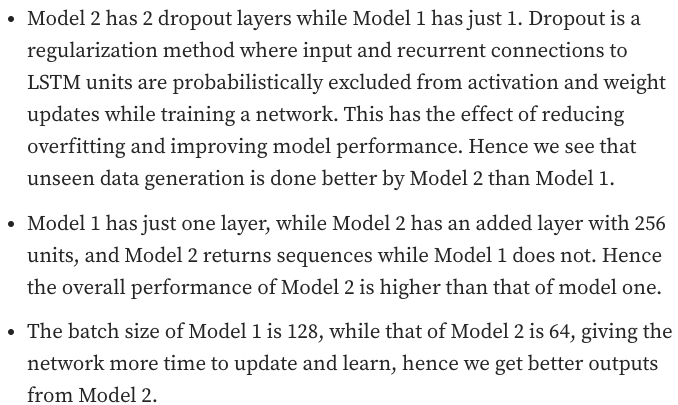